In [393]:
import gensim
import random
import itertools
from math import exp
from sklearn.utils.extmath import softmax
from gensim.models.keyedvectors import KeyedVectors
from Levenshtein import distance as levenshtein_distance
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
model = KeyedVectors.load_word2vec_format('model_prime.txt')

In [360]:
class Word:
    def __init__(self):
        self.word = ''
        self.marker = ''
    
    def __init__(self, s, marker=''):
        self.word = s.lower().replace('\xad', '').replace('ё', 'е')
        self.marker = marker
    
    def __repr__(self):
        return self.word + '_' + self.marker

In [361]:
class Field:
    def __init__(self):
        self.current = 0
        self.n = 25
        self.all = []
    
    def __iter__(self):
        self.current = 0
        return self
    
    def __next__(self):
        if self.current == self.n:
            raise StopIteration
        result = self.all[self.current]
        self.current += 1
        return result

    def __len__(self):
        return len(self.all)
    
    def gen(self):
        with open('words.txt') as f:
            wordlist = f.readline().split()
            wordlist = [x for x in wordlist]
            markers = ['r'] * 9 + ['b'] * 8 + ['d'] * 1 + ['w'] * 7
            self.all = [Word(x, y) for x, y in zip(random.sample(wordlist, self.n), markers)]

In [362]:
x = Field()
x.gen()

In [363]:
def similar_list(wordlist):
    if len(wordlist) == 0:
        return []
    return model.most_similar(positive=wordlist)

In [397]:
LEVENSHTEIN_THRESHOLD = 4
SIMILARITY_THRESHOLD = 0.55
def filtered_similars(wordlist):
    unfiltered = similar_list(wordlist)
    result = []
    for s, dist in unfiltered:
        ok = True
        for parent in wordlist:
            if levenshtein_distance(parent, s) <= LEVENSHTEIN_THRESHOLD or parent in s:
                ok = False
        if ok:
            result.append((s, dist))
    return result

In [398]:
def query(wordlist):
    return filtered_similars(wordlist)

In [399]:
def find_candidates(field, marker='r'):
    good_words = [x.word for x in field if x.marker == marker]
    result = set()
    for i in range(2, len(good_words)):
        for lists in [query(_) for _ in list(itertools.combinations(good_words, i + 1))]:
            for value in lists:
                result.add(value[0])
    return result

In [400]:
def scaling(x):
    return x # exp(x * 10)

In [405]:
# before changes here was just return topn, i havent changed bruteforce yet
def guess(field, word, top_n=-1):
    pairs = []
    for item in field:
        if 'u' in item.marker:
            continue
        pairs.append((scaling(model.similarity(word, item.word)), item))
    if top_n != -1:
        result = [(b, a) for a, b in sorted(pairs)[::-1]]
        return result[:top_n]
    else:
        return softmax(pairs)

In [402]:
def calc_profit(wordlist, marker):
    result = 0
    for x in wordlist:
        if x.marker == marker:
            result += 1
        elif x.marker == 'd':
            result -= 1000
        elif x.marker == 'w':
            continue
        else:
            result -= 1
    return result

In [403]:
def bruteforce(field, candidates, marker):
    all_moves = []
    for number in range(1, len(field) + 1):
        for word in candidates:
            wordlist = [x for x, _ in guess(field, word, number)]
            all_moves.append((calc_profit(wordlist, marker), (word, number)))
    return sorted(all_moves)[::-1]

### ================== here is the bullshit line ===========================

In [370]:
for s in x.all:
    print(s.word, [x[0] for x in query([s.word])])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


мексика ['перу', 'аргентина', 'колумбия', 'эквадор', 'филиппины', 'боливия', 'гватемала', 'бразилия', 'чили', 'индонезия']
баня ['парилка', 'попариться', 'мыться', 'купальня']
кабинет ['приемная', 'ординаторская', 'комната', 'гостиная', 'спальня', 'холл', 'каюта', 'офис', 'учительская']
база ['данных', 'модуль', 'базирование', 'аэродром', 'полигон']
секрет ['тайна', 'тайну', 'ноу-хау', 'загадка', 'тайне', 'полишинель', '-хау']
раковина ['умывальник', 'бачок', 'унитаз', 'моллюск', 'рукомойник', 'тазик', 'ванная', 'кастрюля']
бабочка ['мотылек', 'стрекоза', 'мотылька', 'капустница', 'шмель', 'жук', 'колибри', 'светлячок', 'махаон']
кит ['дельфин', 'кашалот', 'тюлень', 'косатка', 'касатка', 'крокодил', 'моржа', 'касаток']
дыра ['прореха', 'отверстие', 'зиять', 'брешь', 'пролом', 'пробоина']
такса ['болонка', 'собачонка', 'пудель', 'пекинес', 'песик', 'дворняжка', 'собачка']
москва ['ленинград', 'новосибирск', 'рязань', 'воронеж', 'рига', 'киев', 'уфа']
шпион ['диверсант', 'лазутчик', 'аге

In [371]:
model.similarity('уточка', 'утка')

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7408302

In [372]:
levenshtein_distance('a', 'b')

1

In [373]:
levenshtein_distance('ab', 'bab')

1

In [374]:
levenshtein_distance('bac', 'cab')

2

In [375]:
query(['карта', 'двигатель'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('движок', 0.6690325736999512),
 ('мотор', 0.6228243112564087),
 ('навигатор', 0.6082278490066528),
 ('турбина', 0.5876405239105225),
 ('движка', 0.5636513233184814),
 ('навигационный', 0.5631181001663208)]

In [376]:
query(['футбол'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('хоккей', 0.8813096284866333),
 ('баскетбол', 0.823997974395752),
 ('волейбол', 0.758718729019165),
 ('регби', 0.7294275164604187),
 ('теннис', 0.722832202911377),
 ('чемпионат', 0.6435657739639282)]

In [377]:
query(['дельфин'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('кит', 0.692082405090332),
 ('тюлень', 0.6656808257102966),
 ('афалин', 0.6497105360031128),
 ('касатка', 0.6401681303977966),
 ('акула', 0.6354519128799438),
 ('тритон', 0.6238656044006348),
 ('косатка', 0.6150393486022949),
 ('касаток', 0.6128168106079102)]

In [378]:
query(['куб'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('параллелепипед', 0.7026392221450806),
 ('квадрат', 0.619112491607666),
 ('тетраэдр', 0.6175058484077454),
 ('многогранник', 0.5949805974960327),
 ('прямоугольник', 0.588711142539978),
 ('пирамидка', 0.5789507031440735),
 ('шестиугольник', 0.5679293870925903),
 ('шестигранник', 0.5673487782478333),
 ('додекаэдр', 0.564005434513092)]

In [379]:
query(['азия', 'север'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('восток', 0.7258328199386597),
 ('юго-восточный', 0.7253432273864746),
 ('закавказье', 0.7135714292526245),
 ('юго-запад', 0.6970430612564087)]

In [380]:
query(['книга', 'ручка'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('тетрадь', 0.6208901405334473),
 ('тетрадка', 0.6133968830108643),
 ('блокнот', 0.6034168004989624)]

In [381]:
query(['египет'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('месопотамия', 0.7354947328567505),
 ('индия', 0.7078897953033447),
 ('греция', 0.7071681022644043),
 ('эфиопия', 0.7054126262664795),
 ('аравия', 0.6906569004058838),
 ('ассирия', 0.6895437240600586),
 ('тунис', 0.6860137581825256),
 ('вавилония', 0.6827309727668762)]

In [382]:
with open('similar_words') as f:
    tmp = [x.strip() for x in f.readlines()]
    posw = []
    for st in tmp:
        ln = st.split()
        for i in range(1, len(ln)):
            posw.append([ln[0], ln[i]])

In [383]:
with open('negative_words') as f:
    negw = [x.lower().strip().split() for x in f.readlines()]

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


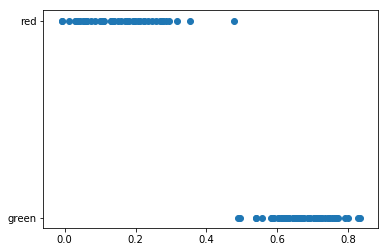

In [384]:
pos = [model.similarity(a, b) for a, b in posw]
neg = [model.similarity(a, b) for a, b in negw]
plt.scatter(pos + neg, ['green'] * len(pos) + ['red'] * len(neg))
plt.show()

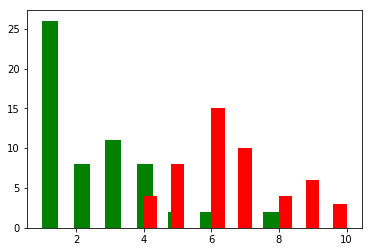

In [385]:
pos = [levenshtein_distance(a, b) for a, b in posw]
neg = [levenshtein_distance(a, b) for a, b in negw]
plt.hist(pos, bins=15, color='green')
plt.hist(neg, bins=15, color='red')
plt.show()

In [386]:
for word in x.all:
    if word.marker == 'r':
        print(word.word)

мексика
баня
кабинет
база
секрет
раковина
бабочка
кит
дыра


In [387]:
find_candidates(x.all, 'r')

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


{'-колосися',
 'appid',
 'http://www.proza.ru/2012/09/27/1573',
 'opinionform',
 'window.settings.type',
 'аквариум',
 'аллигатор',
 'антарктида',
 'апартамент',
 'аргентина',
 'аризона',
 'атлантика',
 'атлантический',
 'аэродром',
 'бассейн',
 'бильярдная',
 'боливия',
 'бордель',
 'бразилия',
 'будуар',
 'бунгало',
 'бункер',
 'бытовка',
 'ванная',
 'ванный',
 'веранда',
 'вигвам',
 'водоем',
 'возможностно',
 'воронка',
 'вулсини',
 'гавайи',
 'галапагосский',
 'гальюн',
 'гватемала',
 'гондурас',
 'гонконг',
 'гостиная',
 'дельфин',
 'джакузи',
 'душевая',
 'душевой',
 'жемчужница',
 'зеландия',
 'индия',
 'индонезия',
 'исландия',
 'италия',
 'каймановый',
 'калифорния',
 'камбуз',
 'каморка',
 'кандейка',
 'каптерка',
 'капустница',
 'каракатица',
 'кастрюля',
 'кашалот',
 'кашалотовый',
 'кают-компания',
 'кладовка',
 'колибри',
 'колодец',
 'колумбия',
 'комната',
 'коморка',
 'контейнер',
 'контора',
 'конференц',
 'коралловый',
 'коровник',
 'косатка',
 'коста-рика',
 'котел

In [406]:
guess(x, 'япония', 2)

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(мексика_r, 0.69578326), (москва_b, 0.40094012)]

In [407]:
bruteforce(x, find_candidates(x.all, 'r'), 'r')

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(7, ('теплица', 11)),
 (7, ('теплица', 8)),
 (7, ('серверная', 13)),
 (7, ('серверная', 12)),
 (6, ('хранилище', 12)),
 (6, ('хранилище', 9)),
 (6, ('теплица', 12)),
 (6, ('теплица', 10)),
 (6, ('теплица', 9)),
 (6, ('теплица', 7)),
 (6, ('серверная', 14)),
 (6, ('серверная', 11)),
 (6, ('серверная', 10)),
 (6, ('прачечная', 8)),
 (6, ('отсек', 10)),
 (5, ('шкаф', 16)),
 (5, ('хранилище', 13)),
 (5, ('хранилище', 11)),
 (5, ('хранилище', 10)),
 (5, ('хранилище', 8)),
 (5, ('хранилище', 7)),
 (5, ('хранилище', 6)),
 (5, ('хранилище', 5)),
 (5, ('хижина', 5)),
 (5, ('теплица', 6)),
 (5, ('сушилка', 5)),
 (5, ('сливной', 18)),
 (5, ('серверная', 17)),
 (5, ('серверная', 15)),
 (5, ('серверная', 9)),
 (5, ('серверная', 8)),
 (5, ('сарайчик', 5)),
 (5, ('сапропелистый', 5)),
 (5, ('резервуар', 5)),
 (5, ('рапан', 14)),
 (5, ('рапан', 13)),
 (5, ('разлом', 6)),
 (5, ('разлом', 5)),
 (5, ('прореха', 15)),
 (5, ('прореха', 13)),
 (5, ('пробоина', 17)),
 (5, ('предбанник', 8)),
 (5, ('предбанн